## License

This notebook is a conversion of a Sentinel Hub evalscript and is licensed under
**CC-BY-SA-4.0**.

Original evalscript: https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/hollstein/  
Source: Sentinel Hub Custom Scripts (CC-BY-SA-4.0)  
Conversion: Development Seed (openEO-UDP project)


# Hollstein Cloud Classification

Cloud, cirrus, and shadow detection is among the early processing steps in remote sensing that enables many downstream applications. Robust classification of these features, along with snow and water, is essential for atmospheric correction, surface reflectance retrieval, and image co-registration. 

This notebook demonstrates how to detect clouds, cirrus, snow, shadows, and clear sky using the decision tree algorithm explained in [Hollstein et al., (2016)](https://www.mdpi.com/2072-4292/8/8/666#). The algorithm is applied to top-of-atmosphere reflectance spectra from Sentinel-2 L1C imagery.

Sentinel-2 MSI offers optimized bands for Earth observation applications, including the detection of visible and sub-visible cirrus clouds, the cirrus channel (B10), which is essential in the decision tree algorithm introduced in this notebook.

The algorithm was originally implemented as a Sentinel Hub Evalscript and has now been translated to openEO processes to enable its deployment across different remote computing resources. This notebook demonstrates the openEO implementation and compares the processing performance across multiple Earth Observation backend providers, including the Copernicus Data Space Ecosystem and OpenEO-Titiler.


## Import Required Libraries

We begin by importing the necessary Python libraries for data processing and visualization.

In [29]:
import openeo
import matplotlib.pyplot as plt
from PIL import Image
from openeo.processes import subtract, divide, array_create, if_

## Define Area of Interest

Define the spatial extent for our analysis. This example uses coordinates for an area in Croatia

In [30]:
spatial_extent = {"west" : 12.3793, "south" : 45.8996, "east" : 12.7918, "north" : 46.1364}

## Executing the Cloud Detection Algorithm in OpenEO-Titiler Backend

In [ ]:
connection = openeo.connect(
    url="https://api.explorer.eopf.copernicus.eu/openeo"
    # url="http://127.0.0.1:8081/"
).authenticate_oidc_authorization_code()

## Load Sentinel-2 L2A Data 

Load Sentinel-2 L2A (bottom-of-atmosphere reflectance) data. We need the same bands as needed for Sentinel-2 L1C for cloud detection, except **B10** as it is not available for Sentinel-2 L2A

In [ ]:
s2cube = connection.load_collection(
    "sentinel-2-l2a",
    spatial_extent=spatial_extent,
    temporal_extent=["2025-05-12", "2025-05-13"], # 
    bands=[
        "reflectance|b01",
        "reflectance|b02",
        "reflectance|b03",
        "reflectance|b04",
        "reflectance|b05",
        "reflectance|b06",
        "reflectance|b07",
        "reflectance|b8a",
        "reflectance|b09",
        "reflectance|b11"
    ],
)

s2cube = s2cube.reduce_dimension(dimension="time", reducer="first")

## Decision Tree for Cloud Detection

In [ ]:
def cloud_detection_algorithm(data):
    B01, B02, B03, B04, B05, B06, B07, B8A, B09, B11 = (
        data[0],
        data[1],
        data[2],
        data[3],
        data[4],
        data[5],
        data[6],
        data[7],
        data[8],
        data[9],
    )

    gain = 2.5

    # Define color mapping
    clear = array_create([B04 * gain, B03 * gain, B02 * gain])
    shadow = array_create([B04 * gain, B03 * gain, B02 * gain])

    # Spatial ones template
    ones = B04 * 0 + 1

    water = array_create([ones * 0.1, ones * 0.1, ones * 0.7])
    cirrus = array_create([ones * 0.8, ones * 0.1, ones * 0.1])  # Red
    cloud = array_create([ones * 0.3, ones * 0.3, ones * 1.0])  # Blue
    snow = array_create([ones * 1.0, ones * 0.8, ones * 0.4])

    # Decision tree
    result = if_(
        B03 < 0.319,
        if_(
            B8A < 0.166,
            if_(
                (subtract(B03, B07)) < 0.027,
                if_((subtract(B09, B11)) < -0.097, clear, shadow),
                if_((subtract(B09, B11)) < 0.021, water, shadow),
            ),
            if_(
                B02 < 0.2, # Instead of checking if (divide(B02, B10)) < 14.689, we created an arbitrary checking for green band
                if_((divide(B02, B09)) < 0.788, clear, cirrus),
                clear,
            ),
        ),
        if_(
            (divide(B05, B11)) < 4.330,
            if_(
                B11 < 0.3, # Instead of checking (subtract(B11, B10)) < 0.255, we created a check for SWIR
                if_((subtract(B06, B07)) < -0.016, cloud, cirrus),
                if_(B01 < 0.300, clear, cloud),
            ),
            if_(B03 < 0.525, if_((divide(B01, B05)) < 1.184, clear, shadow), snow),
        ),
    )

    return result

In [ ]:
hollstein_cloud = s2cube.apply_dimension(
    dimension="bands",
    process=cloud_detection_algorithm
)

hollstein_cloud = hollstein_cloud.linear_scale_range(input_min=0, input_max=1, output_min=0, output_max=255)

hollstein_cloud = hollstein_cloud.save_result("PNG")

In [ ]:
# Send job to backend and download the result
hollstein_cloud.download("hollstein_cloud_eopf.png")

## Visualize the Result From OpenEO-Titiler Backend

The second image is generated in the OpenEO-Titiler backend with the following requirements:

- **Excluding B10**: 

B10 (SWIR-Cirrus, 1373.5 nm) is unavailable in Sentinel-2 L2A imagery provided by the OpenEO-Titiler backend. The following modifications are not backed by scientific research, but serve to replicate similar visualization results as using Sentinel-2 L1C with B10, while enabling performance comparisons between different OpenEO backends.  

To approximate the original algorithm behavior, we first check if the blue band is relatively dark (`B02 < 0.2`) as a proxy for distinguishing clear sky from cirrus clouds. This replaces the original `(B02/B10) < 14.689` condition, which exploited the unique properties of the B10. At this wavelength, the atmosphere is mostly opaque due to strong water vapor absorption in the planetary boundary layer (the lower few kilometers of atmosphere). Since cirrus clouds form well above this water vapor layer, any reflectance detected at B10 must originate from these high-altitude clouds. A low B02/B10 ratio indicates strong cirrus reflectance relative to the blue band, revealing thin ice clouds that might otherwise be invisible.

Similarly, the original `(B11-B10) < 0.255` condition compared two SWIR bands to detect cirrus. A small difference indicates elevated B10 values, which signal the presence of high-altitude scattering above the water vapor absorption layer. Our simplified condition `B11 < 0.3` attempts to approximate this by checking for relatively low SWIR reflectance, though it lacks the atmospheric discrimination that makes B10 effective for cirrus detection.

*However, this algorithm is not intended for discriminating cloud types, rather to replicate the original algorithm using B10 in another openEO backend to evaluate execution processing time.*

- **Array broadcasting**: 

The algorithm requires broadcasting arrays to identical x,y dimensions when creating color arrays for water, cirrus, clouds, and snow classifications.

- **Processing time and limitations**: 

Job execution takes approximately 13 seconds regardless of area coverage. However, processing larger areas may result in:
   - Geometric distortion from on-the-fly re-projection
   - PNG export failures with Array Index Out of Bounds errors
   - **Solution**: Use `.tif` format instead of PNG for large area exports

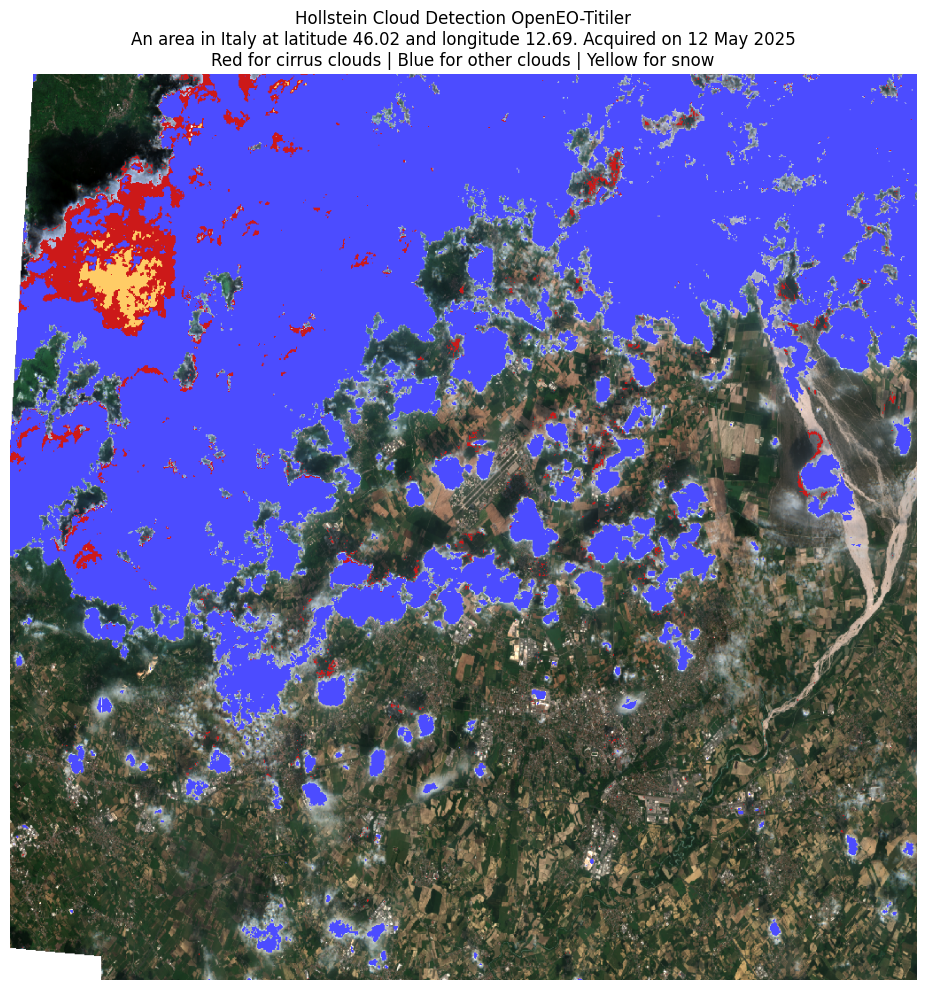

In [22]:
# Load and display the image (With Sentinel L2A with modification au lieu using B10, need to create spatial ones, in openEO titiler backend, takes 13 seconds)
img = Image.open("hollstein_cloud_eopf.png")

fig, ax = plt.subplots(figsize=(14, 10), dpi=100)
ax.imshow(img)
ax.set_title(
    "Hollstein Cloud Detection OpenEO-Titiler\n"
    "An area in Italy at latitude 46.02 and longitude 12.69. Acquired on 12 May 2025\n"
    "Red for cirrus clouds | Blue for other clouds | Yellow for snow",
    fontsize=12,
)
ax.axis("off")
plt.tight_layout()
plt.show()

To replicate the visualization below, run the algorithm again with the following spatial extent for an area in Slovenia using Sentinel L1C imagery in CDSE backend.  
`spatial_extent = {"west" : 14.95484125321093, "south" : 45.80183674806176, "east" : 15.323545428919687, "north" : 45.95608490378885}`

In [ ]:
# Load and display the image
img = Image.open("hollstein_cloud.png")

fig, ax = plt.subplots(figsize=(14, 10), dpi=100)
ax.imshow(img)
ax.set_title(
    "Hollstein Cloud Detection\n"
    "An area in Slovenia at latitude 45.85 and longitude 15.14. Acquired on 27 December 2025\n"
    "Red for cirrus clouds | Blue for other clouds | Yellow for snow",
    fontsize=12,
)
ax.axis("off")
plt.tight_layout()
plt.show()